In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os


import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

In [3]:
# M1 data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
M1 = []
M1_names = []
for root, dirs, files in os.walk('../M1/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1.append(io.loadmat(root + '/' + file))
                M1_names.append(root + '/' + file)

In [3]:
# Microcolumn data
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
MicroColumn = []
MicroColumn_names = []
for root, dirs, files in os.walk('../Microcolumn/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                MicroColumn.append(io.loadmat(root + '/' + file))
                MicroColumn_names.append(root + '/' + file)

In [55]:
# First data that was available
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
Prel = []
Prel_names = []
for root, dirs, files in os.walk('../data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                Prel.append(io.loadmat(root + '/' + file))
                Prel_names.append(root + '/' + file)

In [50]:
Prel[1]

{'Trace_1_1_10_1': array([[ 0.00000000e+00, -2.18750007e-04],
        [ 4.00000000e-05, -2.50000012e-04],
        [ 8.00000000e-05, -2.18750007e-04],
        ...,
        [ 8.99880000e-01, -2.50000012e-04],
        [ 8.99920000e-01, -2.50000012e-04],
        [ 8.99960000e-01, -1.56249997e-04]]),
 'Trace_1_1_10_2': array([[ 5.00000000e-06, -7.13865757e-02],
        [ 4.50000000e-05, -7.14184716e-02],
        [ 8.50000000e-05, -7.14457110e-02],
        ...,
        [ 8.99885000e-01, -7.01547340e-02],
        [ 8.99925000e-01, -7.01586902e-02],
        [ 8.99965000e-01, -7.01612532e-02]]),
 'Trace_1_1_10_3': array([[ 1.00000000e-05, -4.98926383e-05],
        [ 5.00000000e-05, -4.95350541e-05],
        [ 9.00000000e-05, -4.91754654e-05],
        ...,
        [ 8.99890000e-01, -1.84710152e-05],
        [ 8.99930000e-01, -1.80711922e-05],
        [ 8.99970000e-01, -1.76712638e-05]]),
 'Trace_1_1_10_4': array([[ 1.00000000e-05, -9.37500008e-05],
        [ 5.00000000e-05, -3.12500015e-05],
   

In [ ]:
# M1 data asc files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root)
M1_asc = []
for root, dirs, files in os.walk('../M1/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1_asc.append(io.loadmat(root + '/' + file))
destinations = ['../M1/L5/01 02 2018/sample1splitfiles/', '../M1/L5/01 02 2018/sample4splitfiles/', \
                '../M1/L5/01 03 2018/sample2splitfiles/', '../M1/L5/01 03 2018/sample7splitfiles/', \
                '../M1/L5/01 04 2018/sample3splitfiles/']
dictionary = dict([('files', M1_asc), ('destinations', destinations)])


In [145]:
len(M1)

231

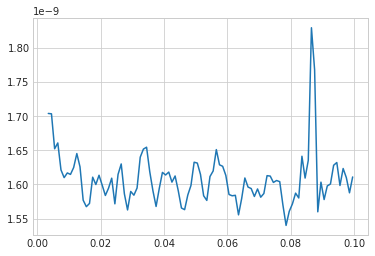

In [72]:
plt.plot(VCM[2]['Trace_1_5_1_3'][:,0], VCM[2]['Trace_1_5_1_3'][:,1])

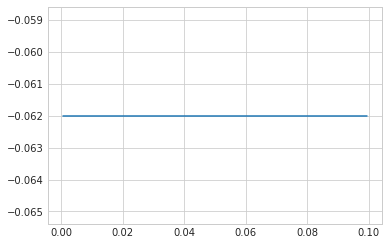

In [75]:
plt.plot(VCM[2]['Trace_1_5_1_4'][:, 0], VCM[2]['Trace_1_5_1_4'][:, 2])

In [43]:
# M1 L5 .asc data
# '../M1/L5/01 02 2018/01 02 2018 sample 1.asc' apparantly is redundant, a .mat file exists already for that sample
files = ['../M1/L5/01 02 2018/01 02 2018 sample 4.asc', \
         '../M1/L5/01 03 2018/01 03 2018 sample 2.asc', '../M1/L5/01 03 2018/01 03 2018 sample 7.asc', \
         '../M1/L5/01 04 2018/01 04 2018 sample 3.asc']

# '../M1/L5/01 02 2018/sample1splitfiles/' is the redundant subdirectory that would have to be made
destinations = ['../M1/L5/01 02 2018/sample4splitfiles/', \
                '../M1/L5/01 03 2018/sample2splitfiles/', '../M1/L5/01 03 2018/sample7splitfiles/', \
                '../M1/L5/01 04 2018/sample3splitfiles/']
dictionary = dict([('files', files), ('destinations', destinations)])

In [6]:
def data_preparation(data, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.
    num = list(data)[0].split('_')[2]
    n_samp = data[list(data.keys())[0]].shape[0] # Amount of timepoints
    dt = data[list(data.keys())[0]][1, 0] - data [list(data.keys())[0]][0, 0] # Time step
    time = np.arange(0,n_samp*dt,dt)
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    for i in np.arange(1, 12, 1):
        voltage_trace = data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]
        object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*voltage_trace, start = 0.1, end = 0.7, filter = 10)
        Vm = object_ephys._get_baseline_voltage()
        Vm_tuple.append(Vm)
    Vm = np.mean(np.array(Vm_tuple))
    
    # The trace where the voltage does not differ much with the membrane voltage is the trace with stimulus current I = 0 pA.
    # We can use this information to determine at which negative current stimulus magnitude the experiment started.
    
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/8 # 3 keys are just '__globals__', '__header__', and '__version__'
                                                          # Recorded from 8 electrodes
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    
    best = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1]) - Vm)
    for i in np.arange(2, stim_paradigm_num + 1, 1, dtype = 'int'):
        best_temp = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    start_current_impulse = -(curr_index_0 - 1)*current_step # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800] #After that the cell might die and it's probably innecessary for the analysis
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp,len(current)))
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage, (curr_index_0 - 1) # -1 since the current and voltage vector start at 0

In [190]:
def data_preparation_asc(file, out_directory, splitLen = 22503, outputBase = 'sample_', el_num = 2, current_step = 20):
    '''Same as data_preparation but handles asc files
        
    Parameters
    ----------
    file : asc file of voltage (V) and time (s) traces
    out_directory : directory to output subfiles to
    splitLen : amount of lines every subfile should contain after splitting the file (optional, 22503 by default)
    outputBase : standard prefix for name of subfiles (optional, 'sample_' by default)
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    '''
    
    # Creating out_directory if it does not exist yet
    if not os.path.exists(out_directory):
        os.makedirs(out_directory)
    
    # Splitting the file
    input = open(file, 'r').read().split('\n') # Make a list of lines splitted by '\n'

    at = 1
    for lines in range(0, len(input), splitLen):
        # First, get the list slice
        outputData = input[lines:lines+splitLen]

        # Now open the output file, join the new slice with newlines
        # and write it out. Then close the file.
        output = open(out_directory + outputBase + str(at) + '.txt', 'w')
        output.write('\r\n'.join(outputData))
        output.close()

        # Increment the counter
        at += 1
    
    
    # Getting the voltage and time traces
    amount_of_subfiles = round(len(input)/splitLen)
    names = ['index', 'time_1', 'V_1', 'time_2', 'V_2', 'time_3', 'V_3', 'time_4', 'V_4', 'time_5', 'V_5', \
         'time_6', 'V_6', 'time_7', 'V_7', 'time_8', 'V_8']
    data = pd.read_csv(out_directory + outputBase + str(1) + '.txt', skiprows = 3, names = names)
    n_samp = data['time_2'].values.shape[0] # Amount of timepoints
    dt = data['time_2'].values[1] - data['time_2'].values[0] # Time step
    time = np.arange(0,n_samp*dt,dt)
    voltage =  np.zeros((n_samp, amount_of_subfiles))
    voltage[:, 0] = 1000*data['V_{}'.format(el_num)].values
    for i in np.arange(2, amount_of_subfiles + 1, 1):
        data = pd.read_csv(out_directory + outputBase + str(i) + '.txt', skiprows = 3, names = names)
        voltage[:, i-1] = 1000*data['V_{}'.format(el_num)].values
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    for i in np.arange(1, 12, 1):
        object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, i], start = 0.1, end = 0.7, filter = 10)
        Vm = object_ephys._get_baseline_voltage()
        Vm_tuple.append(Vm)
    Vm = np.mean(np.array(Vm_tuple))
    
    
    # The trace where the voltage does not differ much with the membrane voltage is the trace with stimulus current I = 0 pA.
    # We can use this information to determine at which negative current stimulus magnitude the experiment started.
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    best = np.abs(np.mean(voltage[:, 0]) - Vm)
    for i in np.arange(1, amount_of_subfiles, 1, dtype = 'int'):
        best_temp = np.abs(np.mean(voltage[:, i]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    start_current_impulse = -curr_index_0*current_step  
    stop_current_impulse = start_current_impulse + (current_step*amount_of_subfiles)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800]
    
    return time, current, voltage, curr_index_0

In [279]:
data = io.loadmat('../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat')

In [14]:
data_plot = M1[5]

In [172]:
data1 = io.loadmat('../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat')

In [280]:
time, current, voltage, curr_index_0 = data_preparation(data)
print('time: ', time)
print('\n\ncurrent: ', current)
print('\n\nvoltage: ', voltage)
print('\n\ncurr_index_0: ', curr_index_0)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-320. -300. -280. -260. -240. -220. -200. -180. -160. -140. -120. -100.
  -80.  -60.  -40.  -20.    0.   20.   40.   60.   80.  100.  120.  140.
  160.  180.  200.  220.  240.  260.  280.  300.  320.  340.  360.  380.
  400.  420.  440.  460.  480.  500.  520.  540.  560.  580.  600.  620.
  640.  660.  680.  700.  720.  740.  760.  780.  800.  820.  840.  860.
  880.  900.  920.  940.  960.  980. 1000. 1020. 1040. 1060. 1080. 1100.
 1120. 1140. 1160. 1180. 1200. 1220. 1240. 1260.]


voltage:  [[-62.84672022 -59.70462039 -56.2733002  ... -64.10356611 -63.78639489
  -63.18134069]
 [-62.84504384 -59.69798192 -56.29773065 ... -64.08812851 -63.79345059
  -63.26726824]
 [-62.84763664 -59.68832597 -56.32648245 ... -64.07336146 -63.80298734
  -63.34682554]
 ...
 [-57.04402924 -56.39185384 -57.24829435 ... -64.13232535 -64.35108185
  -64.57896531]
 [-57.0220612  -56.41865358 -57.27989227 ... -64.0918985

Text(0.5,1,'Raw voltage trace')

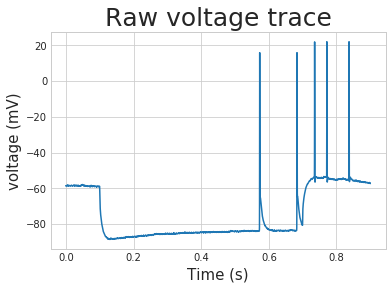

In [294]:
plt.plot(time, voltage[:, 4])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
#plt.savefig('../figs/RawVoltageTraceExample.png')

In [210]:
dvdt = ft.calculate_dvdt(voltage[:, 16], time)

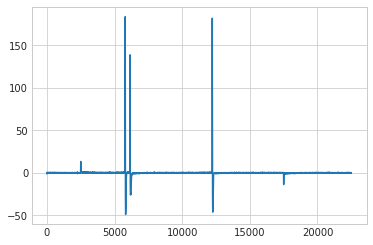

In [211]:
plt.plot(dvdt)

In [70]:
time_asc, current_asc, voltage_asc, curr_index_0_asc = data_preparation_asc('../M1/L5/01 02 2018/01 02 2018 sample 1.asc', \
                                                            '../M1/L5/01 02 2018/sample1splitfiles/')
print('time: ', time_asc)
print('\n\ncurrent: ', current_asc)
print('\n\nvoltage: ', voltage_asc)
print('\n\ncurr_index_0 ', curr_index_0_asc)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-200 -180 -160 -140 -120 -100  -80  -60  -40  -20    0   20   40   60
   80  100  120  140  160  180  200  220  240  260  280  300  320  340
  360  380  400  420  440  460  480  500  520  540  560  580]


voltage:  [[-63.26682866 -61.4560023  -60.96274033 ... -68.39887053 -68.37533414
  -68.57176125]
 [-63.28312308 -61.46592274 -60.94012037 ... -68.37874651 -68.39634478
  -68.57612729]
 [-63.30004334 -61.47384271 -60.91597304 ... -68.35854799 -68.41933727
  -68.58035922]
 ...
 [-58.7365441  -58.89197811 -58.74111876 ... -68.07727367 -68.23767722
  -68.32093745]
 [-58.73662233 -58.89251828 -58.72721598 ... -68.07102263 -68.25365871
  -68.33034754]
 [-58.7377362  -58.89437348 -58.71508271 ... -68.0674836  -68.26816499
  -68.3369413 ]]


curr_index_0  10


# Analysing spikes

In [29]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df])

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection (mV)
        voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection()
        df_features.update({'voltage_deflection': voltage_deflection_v})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances from traces without peaks
            input_resistance = (np.abs(voltage_deflection_v - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        if curr < 0: # We use hyperpolarising steps as required in the object function to estimate the membrane time constant
                     # and E_plateau
            tau = EphysObject.estimate_time_constant()  # Result in seconds!
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})


        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])])
    
    return df, df_related_features

In [313]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

In [314]:
df, df_related_features = extract_spike_features(time, current, voltage)

yup
yup


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


yup
yup
yup
yup
yup
yup


In [312]:
df['clipped']

0      True
0      True
0     False
1     False
0     False
1     False
0     False
1     False
2     False
0     False
0     False
1     False
0     False
1     False
0     False
0     False
1     False
0     False
1     False
2     False
0     False
1     False
2     False
0     False
1     False
2     False
3     False
0     False
1     False
2     False
      ...  
23    False
24    False
25    False
26     True
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25     True
Name: clipped, Length: 5645, dtype: bool

In [296]:
df.iloc[0]

adp_i                            NaN
adp_index                        NaN
adp_t                            NaN
adp_v                            NaN
clipped                         True
downstroke                       NaN
downstroke_index                 NaN
downstroke_t                     NaN
downstroke_v                     NaN
fast_trough_i                    NaN
fast_trough_index                NaN
fast_trough_t                    NaN
fast_trough_v                    NaN
isi_type                         NaN
peak_height                  98.0698
peak_i                          -280
peak_index                     17484
peak_t                       0.69936
peak_v                       15.3592
slow_trough_i                    NaN
slow_trough_index                NaN
slow_trough_t                    NaN
slow_trough_v                    NaN
threshold_i                     -280
threshold_index                17468
threshold_t                  0.69872
threshold_v                 -82.7106
t

In [284]:
df_related_features

,E_plat,adapt,adaptation_index,avg_rate,current,first_isi,input_resistance,isi_cv,latency,mean_isi,median_isi,resting_membrane_potential,spike_count,tau,v_baseline,voltage_deflection
0,-91.932790,NaN,NaN,0.000000,-320.0,NaN,122.982381,NaN,NaN,NaN,NaN,-61.507948,0,0.006418,-61.507948,-100.862309
0,-89.513001,NaN,NaN,0.000000,-300.0,NaN,124.124784,NaN,NaN,NaN,NaN,-58.662676,0,0.006500,-58.662676,-95.900111
0,-86.879895,NaN,NaN,1.666667,-280.0,NaN,NaN,NaN,0.59872,NaN,NaN,-58.267667,1,0.006428,-58.267667,-93.585871
0,-83.724522,NaN,NaN,1.666667,-260.0,NaN,NaN,NaN,0.58908,NaN,NaN,-59.074934,1,0.006751,-59.074934,-91.917947
0,-81.439078,NaN,NaN,3.333333,-240.0,0.11032,NaN,0.000000,0.47236,0.110320,0.11032,-58.659717,2,0.006397,-58.659717,-88.627487
0,-81.279568,NaN,NaN,0.000000,-220.0,NaN,129.288117,NaN,NaN,NaN,NaN,-57.836938,0,0.006739,-57.836938,-86.280324
0,-79.435381,NaN,NaN,3.333333,-200.0,0.19288,NaN,0.000000,0.29164,0.192880,0.19288,-57.094223,2,0.006750,-57.094223,-83.675556
0,-77.858235,NaN,NaN,0.000000,-180.0,NaN,128.617771,NaN,NaN,NaN,NaN,-58.095863,0,0.007031,-58.095863,-81.247061
0,-75.423263,0.603200,NaN,5.000000,-160.0,0.08036,NaN,0.603200,0.08432,0.202520,0.20252,-58.362255,3,0.007239,-58.362255,-78.708284
0,-73.774867,NaN,NaN,1.666667,-140.0,NaN,NaN,NaN,0.45364,NaN,NaN,-58.118992,1,0.007448,-58.118992,-76.232582


In [301]:
def get_cell_features(df, df_related_features, curr_index_0, current_step = 20):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_index_0 : integer of current index where the current = 0 pA
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """
    non_nan_E_plat = ~np.isnan(df_related_features['E_plat'].values)
    Ri, Rm = np.polyfit(df_related_features['current'][non_nan_E_plat].values, \
                            df_related_features['E_plat'][non_nan_E_plat].values, 1)
    #plt.plot(df_related_features['current'][non_nan_E_plat].values, df_related_features['E_plat'][non_nan_E_plat].values)
    Ri = 1000*Ri
    
    # When a cell spikes on hyperpolarisation traces, some tau's can be negative and are excluded.
    indices = df_related_features['tau'].values > 0
    tau = 1000*np.nanmean(df_related_features['tau'].values[indices]) # *1000 to convert to ms
    
    # The cell could have been simply unresponsive, then just put tau and Ri to zero
    # Random threshold of 5 MOhm used now
    if Ri < 5:
        Ri = 0
        tau = 0
    if not df.empty:
    
        max_freq = np.max(df_related_features['spike_count'].values)
    
        non_nan_indexes_AI = ~np.isnan(df_related_features['adaptation_index'].values)
        if non_nan_indexes_AI.any():
            start_index = np.flatnonzero(non_nan_indexes_AI)[0]
            AI = df_related_features['adaptation_index'].values[start_index]
        else:
            AI = 0
    
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[0] - df.loc[0]['threshold_v'].values[0] # Only first peak is considered
            #valid_indexes = AHP_fast < 0 # This excludes the possible strange appearing thresholds for the peaks towards high
            #                     # stimulation current magnitudes
            #AHP = np.nanmean(AHP_fast[valid_indexes])
        else:
            AHP = 0
    
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[0] - df.loc[0]['fast_trough_v'].values[0] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[0] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[0] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[0] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered
            #if df.ix[0]['threshold_v'].size > 1:
            #    threshold_v = df.ix[0]['threshold_v'].values
            #    valid_indexes = np.abs(threshold_v - Rm) > 15
            #    AP_threshold = np.nanmean(df.ix[0]['threshold_v'].values[valid_indexes]) # df.ix[0] to include first peaks only
            #    # TODO: Random threshold 15 used right now to exclude wrong calculated threshold_v's (due to steep depolarisations e.g.)
            #
            #    AP_amplitude = np.nanmean(df.ix[0]['peak_height'].values[valid_indexes]) # only valid thresholds taken into account

    
            #    AP_half_width = 1000*np.nanmean(df.ix[0]['width'].values[valid_indexes]) # only valid thresholds taken into account
            #else: # The size is just one --> requirs a different way of working with the Dataframe
            #    AP_threshold = df.ix[0]['threshold_v']
            #    AP_amplitude = df.ix[0]['peak_height']
            #    AP_half_width = df.ix[0]['width']
            #    if (AP_threshold - Rm) < 15: # Excluded from the analysis, usually these are non-bursting so this shouldn't be true
            #        AP_threshold = 0
            #        AP_amplitude = 0
            #        AP_half_width = 0
            
        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
    
    name_features = ['Rm (mV)', 'Input res (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP half-width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX freq']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

In [302]:
Cell_Features = get_cell_features(df, df_related_features, curr_index_0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [303]:
Cell_Features

,Rm (mV),Input res (MOhm),tau (ms),AP threshold (mV),AP amplitude (mV),AP half-width (ms),AHP (mV),ADP (mV),AI (%),MAX freq
0,-58.994784,100.388061,7.241362,-82.710586,98.069771,NaN,NaN,NaN,25.192012,126


In [31]:
def cell_features(data_tuple, names, el_num = 2, current_step = 20):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features])
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ...

In [27]:
def cell_features_asc(dictionary, splitLen = 22503, outputBase = 'sample_', el_num = 2, current_step = 20):
    """ Analogous to cell_features, but this time the input is a dictionary of files and destinations for the subfiles
    Parameters
    ----------
    dictionary : dictionary of files with voltage and time traces asc type and directories to output the subfiles too.
    splitLen : amount of lines every subfile should contain after splitting the file (optional, 22503 by default)
    outputBase : standard prefix for name of subfiles (optional, 'sample_' by default)
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    Cell_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for file, out_directory in zip(dictionary['files'], dictionary['destinations']):
        time, current, voltage, curr_index_0 = data_preparation_asc(file, out_directory)
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], ignore_index = True)
    All_Cells_Features.insert(0, 'name sample', dictionary['files'])
    return All_Cells_Features.fillna(0)         # Nan values can be considered as 0 for AHP, ADP, ...

In [304]:
# Extracting data and saving the features of every cell in an excel file for M1 .mat files
All_Cells_Features_M1 = cell_features(M1, M1_names)
All_Cells_Features_M1.to_csv('../data/Cell_Features_M1Updated1.csv')

Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 4.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 5.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 7.mat
Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 29 2018/05 29 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 09 2018/01 09 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 11 2018/01 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 10.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 10.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 18 2018/04182018 slice 2cell 1 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04182018 slice 1 cell 1 (left).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 18 2018/04182018 slice 3cell 1 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 18 2018/04182018 slice 6 cell 1 (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 18 2018/04182018 slice 5 cell 1 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 4 (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 2  (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 3 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 4 (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample3 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample2 (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 1 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4 (left).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4 .mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2 (right).mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 slample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 18 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:1343: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [42]:
# Extracting data and saving the features of every cell in an excel file for Microcolumn .mat files
All_Cells_Features_MicroColumn = cell_features(MicroColumn, MicroColumn_names)
All_Cells_Features_MicroColumn.to_csv('../data/Cell_Features_MicroColumnUpdated.csv')

Processing:  ../Microcolumn//12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../Microcolumn//12 19 2017 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../Microcolumn//12 19 2017 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../Microcolumn//12 19 2017 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../Microcolumn//12 19 2017 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [62]:
All_Cells_Features_MicroColumn

,name sample,Rm (mV),Input res (MOhm),tau (ms),AP threshold (mV),AP amplitude (mV),AP half-width (ms),AHP (mV),ADP (mV),AI (%),MAX freq
0,../Microcolumn//12 19 2017 sample 8.mat,-70.766046,73.613734,15.207905,-42.212527,92.703104,1.32,-0.917625,0.0,147.337278,14
0,../Microcolumn//12 19 2017 sample 7.mat,-73.169224,111.357648,14.566180,-38.594961,91.042046,1.28,-0.128251,0.0,172.321429,17
0,../Microcolumn//12 19 2017 sample 2.mat,-72.844822,143.595523,22.872074,-44.374067,93.436345,1.60,-1.033541,0.0,195.406360,18
0,../Microcolumn//12 19 2017 sample 6.mat,-71.176995,96.219377,17.294939,-44.578884,99.789921,1.16,-2.631728,0.0,94.658120,26
0,../Microcolumn//12 19 2017 sample 3.mat,-75.837243,95.759594,13.837487,-40.531136,88.937152,1.56,-1.283478,0.0,201.126126,11


In [75]:
# Extracting data and saving the features of every cell in an excel file for M1/L5 mat files
All_Cells_Features = cell_features(data_tuple, names)
All_Cells_Features.to_excel('../data/Cell_FeaturesM1L5matu.xlsx')

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-package

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable

In [76]:
# Extracting data and saving the features of every cell in an excel file for M1/L5 .asc files
All_Cells_Features_asc = cell_features_asc(dictionary)
All_Cells_Features_asc.to_excel('../data/Cell_FeaturesM1L5ascu.xlsx')

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-package

In [77]:
# Extracting data and saving the features of every cell in an excel file for microcolumn .mat files
All_Cells_Features_C = cell_features(data_tuple_C, names_C)
All_Cells_Features_C.to_excel('../data/Cell_FeaturesMicrocolumnu.xlsx')

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the burst, and `end` is the ISI index immediately following the burst.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:910: RuntimeWarning: invalid value encountered in sqrt
  ISI of the bur

In [60]:
# Extracting data and saving the features of every cell in an excel file for first data available .mat files
All_Cells_Features_Prel = cell_features(Prel, Prel_names)
All_Cells_Features_Prel.to_csv('../data/Cell_Features_PrelUpdated.csv', columns = name_features)

Processing:  ../data//05102017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../data//09012017 slice 3 cell 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../data//01152018 slice 1 cell 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:951: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


Processing:  ../data//01182018 slice 4 cell 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# Plotting information as a sanity check

In [77]:
def plot_info(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    
    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first])
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15)
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15)
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15)
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('Voltage trace in function of time with annotations', fontsize = 25)
    ax.legend(['Trace', 'Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
               'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        plt.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

In [73]:
def plot_info_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [79]:
directory = '../M1/Figures/PlotInfoMultiplePeaks/'
plot_info_all(M1, M1_names, directory)

Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4 (left).mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4 .mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2 (right).mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 slample 8.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 18 sample 4.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:1343: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:1343: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


In [138]:
def plot_info_first_peak(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0] + spike_count

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index[0]
    end_index = fast_trough_index[0] + 50 # Plot 50 time indices after the fast trough index (should always exist)
        # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        return

    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first])

    ax.plot(time[thresh_index[0]], voltage[thresh_index[0], current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index[0]], voltage[upstroke_index[0], current_first], 'r.', ms = 15)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index[0]], voltage[downstroke_index[0], current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index[0]], voltage[fast_trough_index[0], current_first], 'y.', ms = 15)
    if slow_trough_index.size:
        ax.plot(time[slow_trough_index[0]], voltage[slow_trough_index[0], current_first], 'm.')
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', 'Slow trough (if applicable)'])
    else:
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough'])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('First peak annotations (voltage i.f.o. time)', fontsize = 25)

    # Nice annotations

    ax.annotate('', xy = (time[peak_index[0]], voltage[peak_index[0], current_first]), \
                xycoords = 'data', xytext = (time[peak_index[0]], voltage[thresh_index[0], current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkB': 0})
    ax.plot(time[peak_index[0]], voltage[thresh_index[0], current_first], '_', color = 'black', ms = 100)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], '_', color = 'black', ms = 100)


    width_level = (voltage[peak_index[0], current_first] - voltage[thresh_index[0], current_first])/2 + \
                   voltage[thresh_index[0], current_first]
    width_start_index = peak_index[0] - np.flatnonzero(voltage[peak_index[0] : thresh_index[0]:-1, current_first] <= width_level)[0]
    width_end_index = peak_index[0] + np.flatnonzero(voltage[peak_index[0]: fast_trough_index[0], current_first] <=width_level)[0]
    plt.plot(time[width_start_index], voltage[width_start_index, current_first], '|', color = 'black', ms = 100)
    plt.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The half-width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_start_index] to v[width_start_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_start_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_start_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkA': 0})
    ax.annotate('AP half-width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)

    # For the AP amplitude
    ax.annotate('AP amplitude', xy = (time[peak_index[0]], width_level + 20), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [112]:
def plot_info_first_peak_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [140]:
directory = '../M1/Figures/PlotInfoFirstPeak/'
plot_info_first_peak_all(M1, M1_names, directory)

Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 1.mat
Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample3 (right).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample2 (left).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 1 (right).mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4 (left).mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4 .mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2 (right).mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 slample 8.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 18 sample 4.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:1343: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:1343: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


In [123]:
data = io.loadmat('../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat')

In [139]:
plot_info_first_peak(data)

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:946: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
